## Краткое описание

Цель проекта - обучить модель-классификатор, предсказывающую жанр музыкальной композиции по её заданным признакам. Для этого предусмотрены следующие шаги: 1) анализ исходных данных, проверка на пропуски и дубликаты; 2) анализ и выявление закономерностей в количественных и качественных данных; 3) предобработка данных перед машинным обучением; 4) обучение модели и её проверка на обучающем датафрейме. Для измерения качества работы модели будет использована мтерика f1-micro.

## Загрузка библиотек

In [1]:
!pip install -q pyod
!pip install -q feature_engine
!pip install -q imbalanced-learn
!pip install phik

In [2]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault
from sklearn.experimental import enable_iterative_imputer

from phik import phik_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures
from sklearn.feature_selection import mutual_info_classif, SelectKBest

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.metrics import f1_score

from sklearn.ensemble import IsolationForest, RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from imblearn.base import FunctionSampler
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

import joblib
import re

## Загрузка данных

In [3]:
df_train = pd.read_csv('kaggle_music_genre_train.csv')
df_test = pd.read_csv('kaggle_music_genre_test.csv')

## Анализ исходных данных

In [4]:
def analyze_dataset(data):
    print("Первые 5 строк:")
    display(data.head())
    print("\n" + "=" * 50)
    print("\nИнформация о данных:")
    print(data.info())
    print("\n" + "=" * 50)
    print("\nКоличество дубликатов:", data.duplicated().sum())
    print("\n" + "=" * 50)
    print("\nПропуски в данных:")
    print(data.isnull().sum())
    print("\n" + "=" * 50)
    print("\nОписательная статистика:")
    display(data.describe())
    print("\n" + "=" * 50)
    print("\nФорма данных (количество строк, количество столбцов):", data.shape)

In [5]:
analyze_dataset(df_train)

Первые 5 строк:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative




Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), o

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000




Форма данных (количество строк, количество столбцов): (20394, 16)


In [6]:
analyze_dataset(df_test)

Первые 5 строк:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121




Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB
None



,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5099.000000,5099.000000,5099.000000,5.099000e+03,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,4978.000000,5099.000000
mean,55643.871347,0.276324,0.561888,2.173974e+05,0.622030,0.165198,0.197924,-8.630186,0.092718,121.246463,0.465593
std,20762.384803,0.322657,0.170502,1.156374e+05,0.251829,0.311940,0.166241,5.619766,0.100130,29.875950,0.244217
min,20012.000000,0.000002,0.059600,-1.000000e+00,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500
25%,37571.000000,0.016600,0.451000,1.737335e+05,0.465000,0.000000,0.096950,-10.231000,0.035700,96.070250,0.272000
50%,55246.000000,0.120000,0.568000,2.175000e+05,0.660000,0.000157,0.129000,-7.135000,0.048700,120.053500,0.458000
75%,73702.000000,0.460000,0.681000,2.642470e+05,0.826000,0.092750,0.248000,-5.127000,0.096550,141.934250,0.650000
max,91709.000000,0.996000,0.977000,1.360027e+06,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000




Форма данных (количество строк, количество столбцов): (5099, 15)


Перепроверим наличие дубликатов без учёта номера композиции, который уйдёт в индекс.

In [7]:
df_train['instance_id'] = df_train['instance_id'].astype(int)
df_train = df_train.set_index('instance_id', drop=True)

In [8]:
analyze_dataset(df_train)

Первые 5 строк:


,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
instance_id,,,,,,,,,,,,,,,
25143,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
26091,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
87888,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
77021,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
20852,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative




Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20394 entries, 25143 to 86375
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20394 non-null  object 
 1   acousticness      20394 non-null  float64
 2   danceability      20394 non-null  float64
 3   duration_ms       20394 non-null  float64
 4   energy            20394 non-null  float64
 5   instrumentalness  20394 non-null  float64
 6   key               19659 non-null  object 
 7   liveness          20394 non-null  float64
 8   loudness          20394 non-null  float64
 9   mode              19888 non-null  object 
 10  speechiness       20394 non-null  float64
 11  tempo             19952 non-null  float64
 12  obtained_date     20394 non-null  object 
 13  valence           20394 non-null  float64
 14  music_genre       20394 non-null  object 
dtypes: float64(10), object(5)
memory usage: 2.5+ MB
None


Колич

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000




Форма данных (количество строк, количество столбцов): (20394, 15)


In [9]:
df_train = df_train.drop_duplicates(keep='first')

In [10]:
df_test['instance_id'] = df_test['instance_id'].astype(int)
df_test = df_test.set_index('instance_id', drop=True)

In [11]:
analyze_dataset(df_test)

Первые 5 строк:


,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
instance_id,,,,,,,,,,,,,,
48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121




Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5099 entries, 48564 to 47986
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        5099 non-null   object 
 1   acousticness      5099 non-null   float64
 2   danceability      5099 non-null   float64
 3   duration_ms       5099 non-null   float64
 4   energy            5099 non-null   float64
 5   instrumentalness  5099 non-null   float64
 6   key               4941 non-null   object 
 7   liveness          5099 non-null   float64
 8   loudness          5099 non-null   float64
 9   mode              4950 non-null   object 
 10  speechiness       5099 non-null   float64
 11  tempo             4978 non-null   float64
 12  obtained_date     5099 non-null   object 
 13  valence           5099 non-null   float64
dtypes: float64(10), object(4)
memory usage: 597.5+ KB
None


Количество дубликатов: 30


Пропуски в данных:
trac

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5099.000000,5099.000000,5.099000e+03,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,4978.000000,5099.000000
mean,0.276324,0.561888,2.173974e+05,0.622030,0.165198,0.197924,-8.630186,0.092718,121.246463,0.465593
std,0.322657,0.170502,1.156374e+05,0.251829,0.311940,0.166241,5.619766,0.100130,29.875950,0.244217
min,0.000002,0.059600,-1.000000e+00,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500
25%,0.016600,0.451000,1.737335e+05,0.465000,0.000000,0.096950,-10.231000,0.035700,96.070250,0.272000
50%,0.120000,0.568000,2.175000e+05,0.660000,0.000157,0.129000,-7.135000,0.048700,120.053500,0.458000
75%,0.460000,0.681000,2.642470e+05,0.826000,0.092750,0.248000,-5.127000,0.096550,141.934250,0.650000
max,0.996000,0.977000,1.360027e+06,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000




Форма данных (количество строк, количество столбцов): (5099, 14)


Первичный анализ данных продемонстрировал наличие пропусков и неявных дубликатов. Вероятно, одни и те же композиции были внесены дважды. В обоих датафреймах представлены категориальные и количественные данные.

## Анализ категориальных данных

In [12]:
cat_columns_train = df_train.select_dtypes(exclude='number').columns
num_columns_train = df_train.select_dtypes(include='number').columns
cat_columns_test = df_test.select_dtypes(exclude='number').columns
num_columns_test = df_test.select_dtypes(include='number').columns

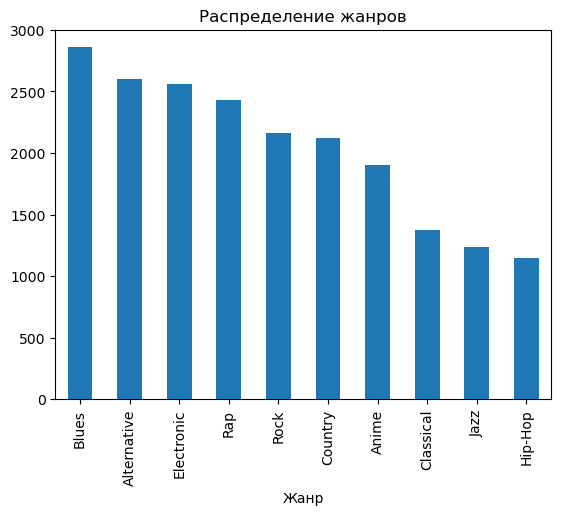

Соотношение количества композиций в каждой категории жанра:
Blues          2858
Alternative    2601
Electronic     2563
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64


In [13]:
df_train['music_genre'].value_counts().plot(kind='bar')
plt.xlabel('Жанр')
plt.title('Распределение жанров')
plt.show()

print("Соотношение количества композиций в каждой категории жанра:")
print(df_train['music_genre'].value_counts())

In [14]:
unique_keys_train = df_train['key'].unique()
print("Уникальные значения столбца 'key' в df_train:")
for key in unique_keys_train:
    print(key)

unique_keys_test = df_test['key'].unique()
print("\nУникальные значения столбца 'key' в df_test:")
for key in unique_keys_test:
    print(key)

Уникальные значения столбца 'key' в df_train:
D
A
E
G#
C
D#
A#
F
F#
nan
G
C#
B

Уникальные значения столбца 'key' в df_test:
A#
G#
A
B
D
F#
F
G
C
nan
D#
C#
E


In [15]:
mode_counts_train = df_train['mode'].value_counts(dropna=False)
unique_modes_train = df_train['mode'].unique()

print("Уникальные значения столбца 'mode' в df_train и их соотношения:")
for mode in unique_modes_train:
    count = mode_counts_train.get(mode, 0)  
    percentage = count / len(df_train) * 100
    print(f"Значение '{mode}': {count} ({percentage:.2f}%)")

mode_counts_test = df_test['mode'].value_counts(dropna=False) 
unique_modes_test = df_test['mode'].unique()

print("\nУникальные значения столбца 'mode' в df_test и их соотношения:")
for mode in unique_modes_test:
    count = mode_counts_test.get(mode, 0) 
    percentage = count / len(df_test) * 100
    print(f"Значение '{mode}': {count} ({percentage:.2f}%)")

Уникальные значения столбца 'mode' в df_train и их соотношения:
Значение 'Major': 12827 (62.90%)
Значение 'Minor': 7060 (34.62%)
Значение 'nan': 506 (2.48%)

Уникальные значения столбца 'mode' в df_test и их соотношения:
Значение 'Minor': 1773 (34.77%)
Значение 'Major': 3177 (62.31%)
Значение 'nan': 149 (2.92%)


In [16]:
print("Соотношение уникальных значений 'obtained_date' в df_train:")
print(df_train['obtained_date'].value_counts(normalize=True))

print("\nСоотношение уникальных значений 'obtained_date' в df_test:")
print(df_test['obtained_date'].value_counts(normalize=True))

Соотношение уникальных значений 'obtained_date' в df_train:
4-Apr    0.903938
3-Apr    0.074732
5-Apr    0.014221
1-Apr    0.007110
Name: obtained_date, dtype: float64

Соотношение уникальных значений 'obtained_date' в df_test:
4-Apr    0.901549
3-Apr    0.077466
5-Apr    0.012748
1-Apr    0.008237
Name: obtained_date, dtype: float64


В соотношении качественных данных жанров, тонов и модальностей, а также дат загрузки наблюдается дисбаланс. 

## Анализ количественных данных

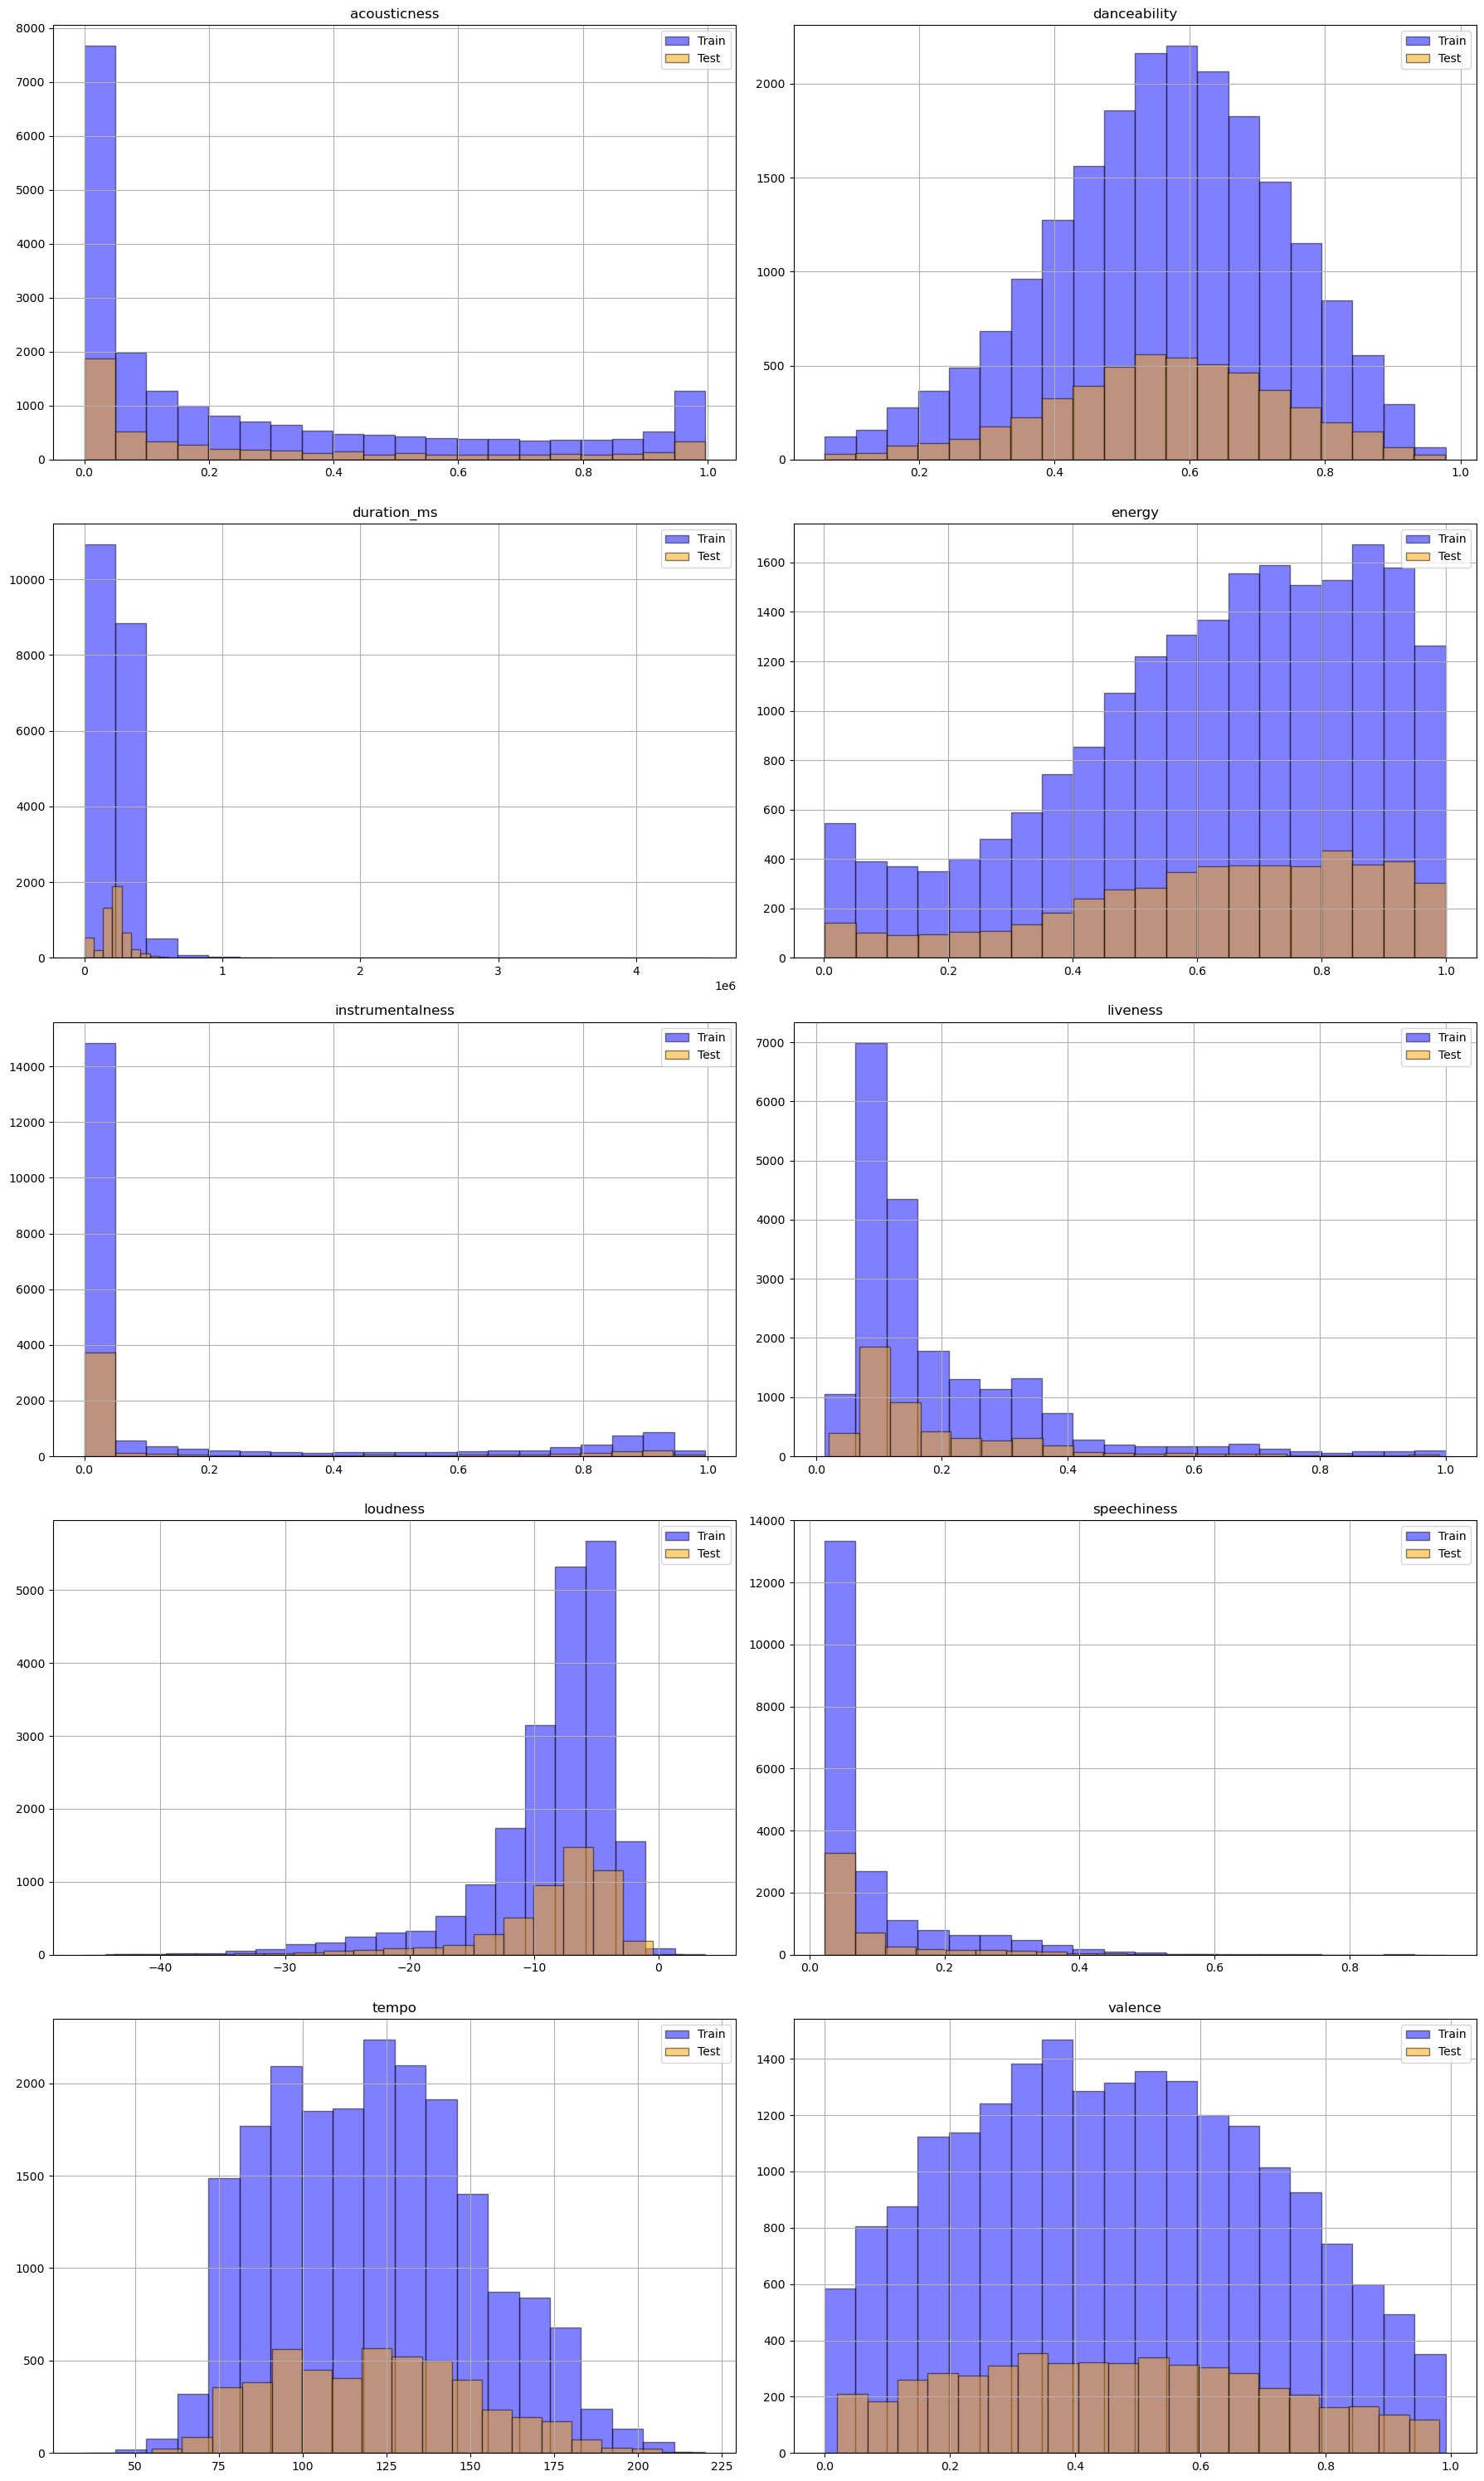

In [17]:
num_cols = 2
num_rows = (len(num_columns_train) + num_cols - 1) // num_cols
plt.figure(figsize=(18, 6 * num_rows))


for i, column in enumerate(num_columns_train):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(df_train[column], bins=20, color='blue', edgecolor='black', alpha=0.5, label='Train')
    plt.hist(df_test[column], bins=20, color='orange', edgecolor='black', alpha=0.5, label='Test')
    plt.title(f'{column}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
def num_values_boxplot (data):
    print (col)
    display (data[col].describe())
    data.boxplot(column=col)
    plt.show()
    return

Распределение количественных значений в df_train
acousticness


count    20393.000000
mean         0.274788
std          0.321651
min          0.000000
25%          0.015200
50%          0.120000
75%          0.470000
max          0.996000
Name: acousticness, dtype: float64

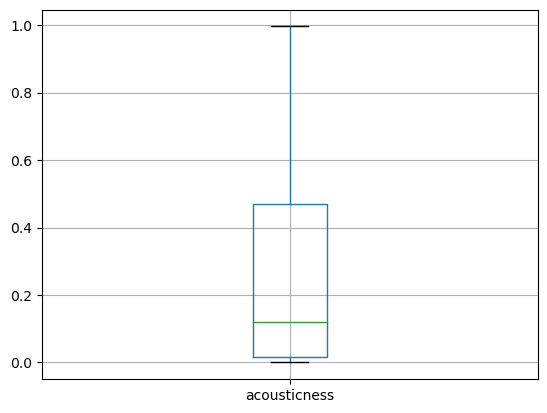

danceability


count    20393.000000
mean         0.561983
std          0.171902
min          0.060000
25%          0.451000
50%          0.570000
75%          0.683000
max          0.978000
Name: danceability, dtype: float64

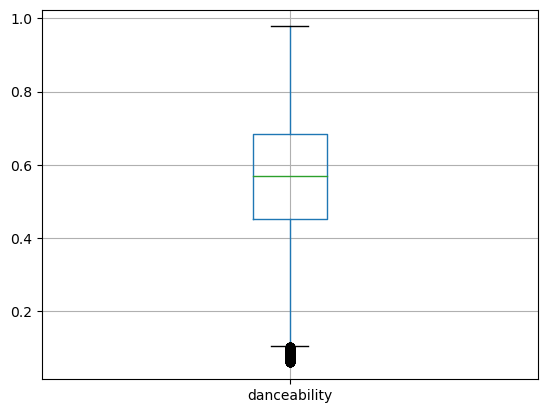

duration_ms


count    2.039300e+04
mean     2.203770e+05
std      1.267312e+05
min     -1.000000e+00
25%      1.775170e+05
50%      2.195330e+05
75%      2.660000e+05
max      4.497994e+06
Name: duration_ms, dtype: float64

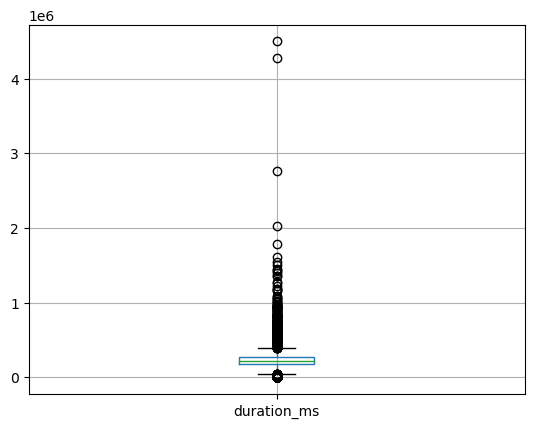

energy


count    20393.000000
mean         0.625273
std          0.251243
min          0.001010
25%          0.470000
50%          0.666000
75%          0.830000
max          0.999000
Name: energy, dtype: float64

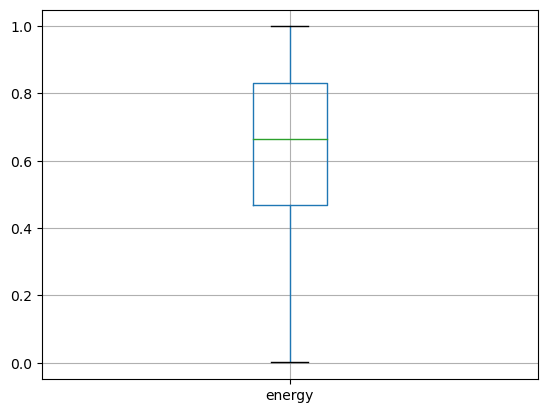

instrumentalness


count    20393.000000
mean         0.159997
std          0.306508
min          0.000000
25%          0.000000
50%          0.000144
75%          0.084500
max          0.996000
Name: instrumentalness, dtype: float64

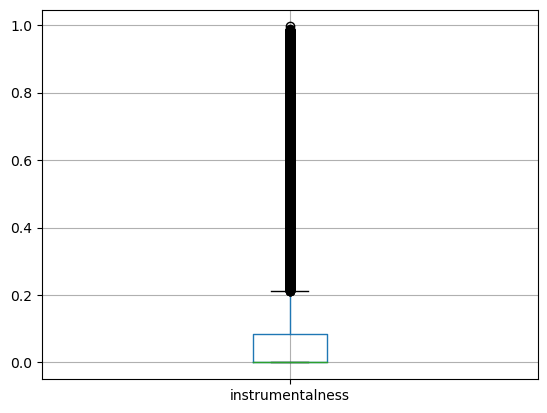

liveness


count    20393.000000
mean         0.198534
std          0.166744
min          0.013600
25%          0.097300
50%          0.130000
75%          0.253000
max          1.000000
Name: liveness, dtype: float64

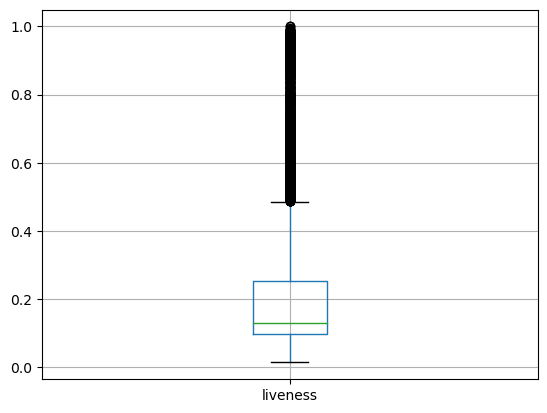

loudness


count    20393.000000
mean        -8.552956
std          5.500048
min        -44.406000
25%        -10.256000
50%         -7.052000
75%         -5.054000
max          3.744000
Name: loudness, dtype: float64

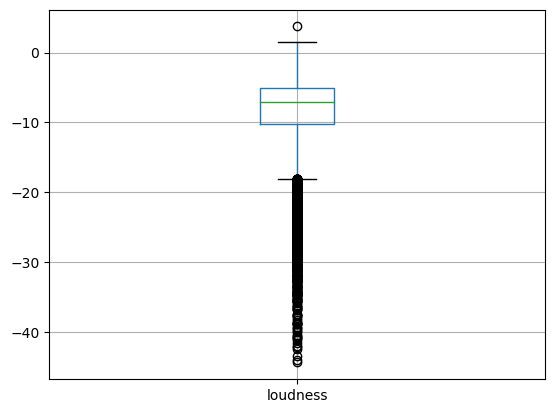

speechiness


count    20393.000000
mean         0.091351
std          0.097737
min          0.022300
25%          0.035600
50%          0.049000
75%          0.095500
max          0.942000
Name: speechiness, dtype: float64

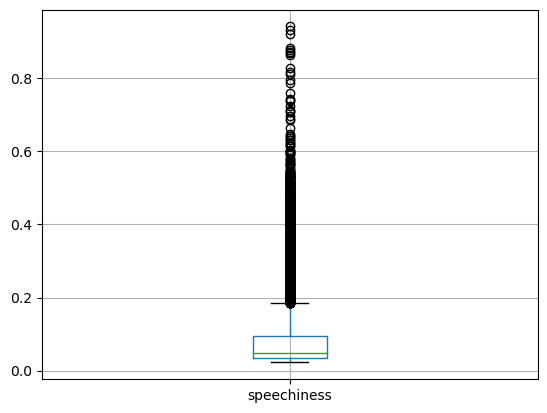

tempo


count    19951.000000
mean       120.941985
std         30.428258
min         34.765000
25%         95.921500
50%        120.012000
75%        141.966500
max        220.041000
Name: tempo, dtype: float64

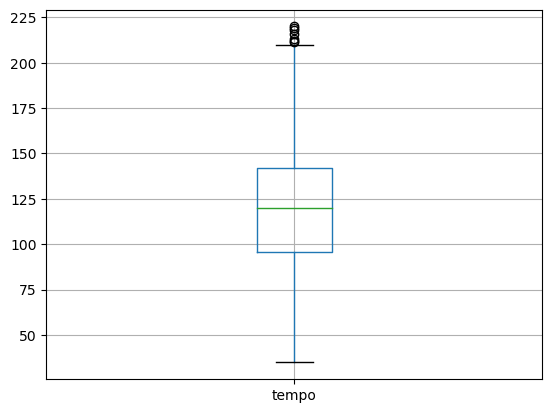

valence


count    20393.000000
mean         0.464593
std          0.243391
min          0.000000
25%          0.272000
50%          0.457000
75%          0.653000
max          0.992000
Name: valence, dtype: float64

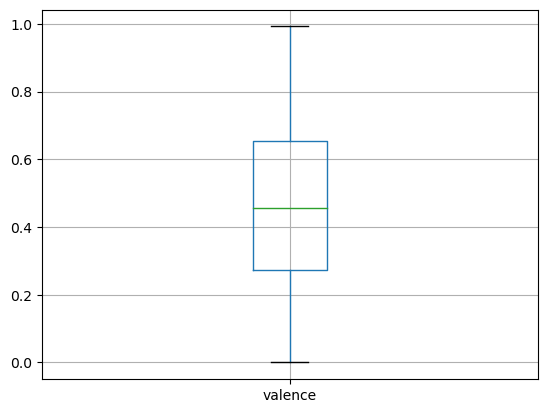

In [19]:
print('Распределение количественных значений в df_train')
for col in num_columns_train:
    num_values_boxplot(df_train)

Распределение количественных значений в df_test
acousticness


count    5099.000000
mean        0.276324
std         0.322657
min         0.000002
25%         0.016600
50%         0.120000
75%         0.460000
max         0.996000
Name: acousticness, dtype: float64

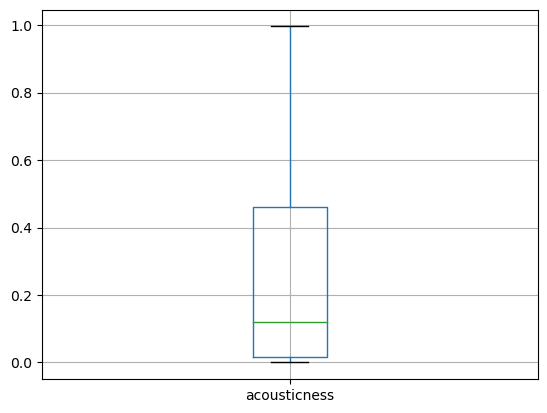

danceability


count    5099.000000
mean        0.561888
std         0.170502
min         0.059600
25%         0.451000
50%         0.568000
75%         0.681000
max         0.977000
Name: danceability, dtype: float64

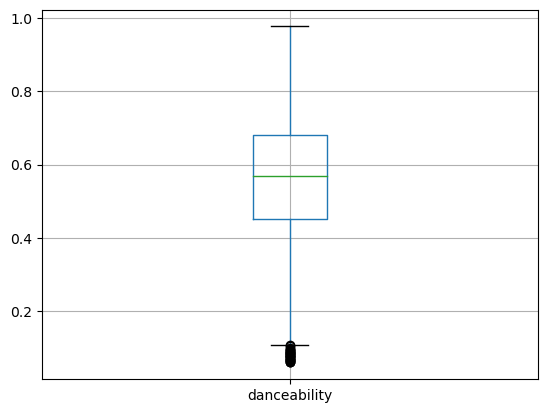

duration_ms


count    5.099000e+03
mean     2.173974e+05
std      1.156374e+05
min     -1.000000e+00
25%      1.737335e+05
50%      2.175000e+05
75%      2.642470e+05
max      1.360027e+06
Name: duration_ms, dtype: float64

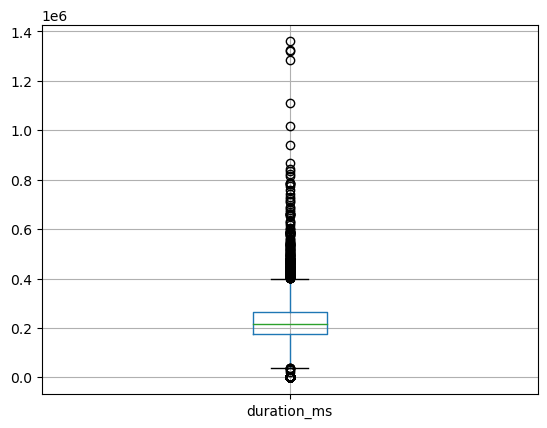

energy


count    5099.000000
mean        0.622030
std         0.251829
min         0.001540
25%         0.465000
50%         0.660000
75%         0.826000
max         0.999000
Name: energy, dtype: float64

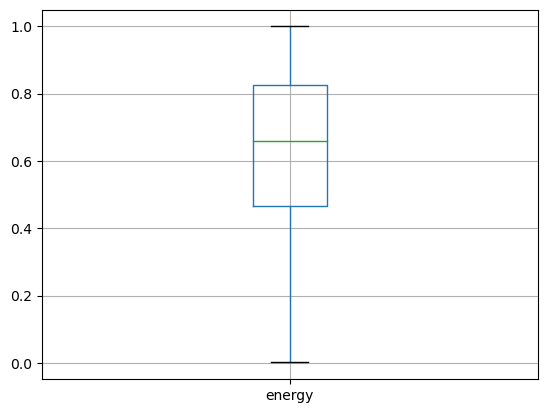

instrumentalness


count    5099.000000
mean        0.165198
std         0.311940
min         0.000000
25%         0.000000
50%         0.000157
75%         0.092750
max         0.994000
Name: instrumentalness, dtype: float64

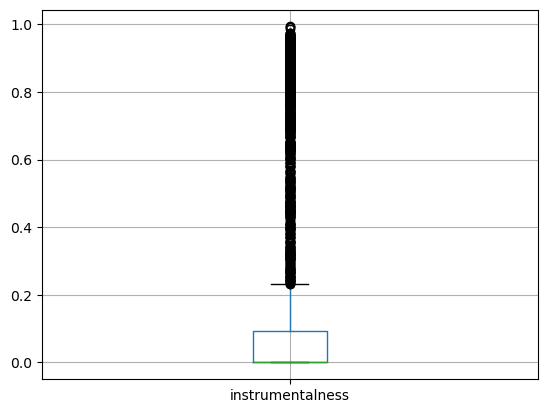

liveness


count    5099.000000
mean        0.197924
std         0.166241
min         0.020400
25%         0.096950
50%         0.129000
75%         0.248000
max         0.990000
Name: liveness, dtype: float64

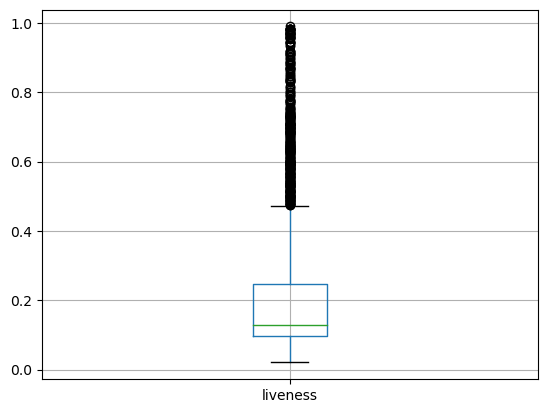

loudness


count    5099.000000
mean       -8.630186
std         5.619766
min       -46.122000
25%       -10.231000
50%        -7.135000
75%        -5.127000
max         1.949000
Name: loudness, dtype: float64

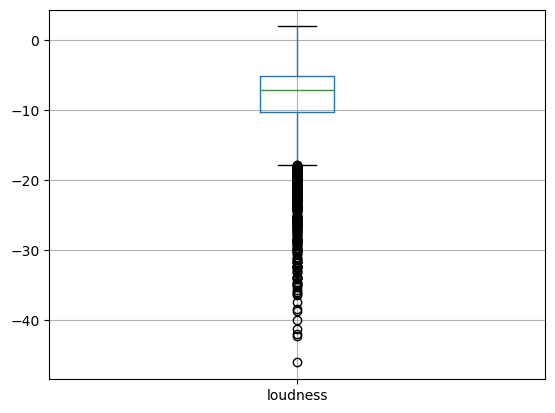

speechiness


count    5099.000000
mean        0.092718
std         0.100130
min         0.022600
25%         0.035700
50%         0.048700
75%         0.096550
max         0.918000
Name: speechiness, dtype: float64

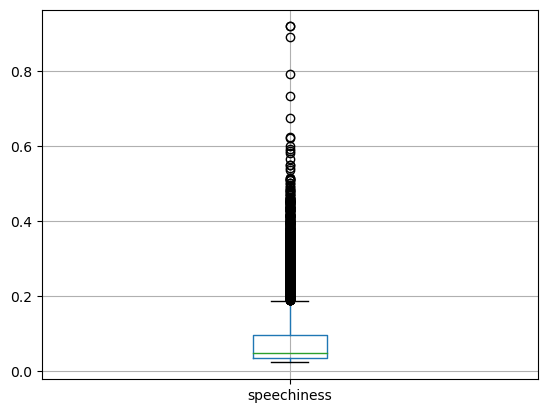

tempo


count    4978.000000
mean      121.246463
std        29.875950
min        37.114000
25%        96.070250
50%       120.053500
75%       141.934250
max       216.029000
Name: tempo, dtype: float64

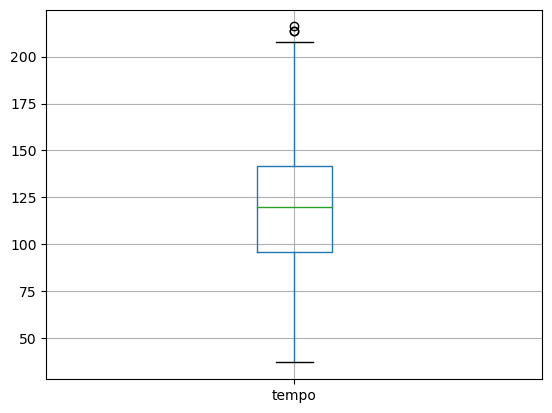

valence


count    5099.000000
mean        0.465593
std         0.244217
min         0.020500
25%         0.272000
50%         0.458000
75%         0.650000
max         0.982000
Name: valence, dtype: float64

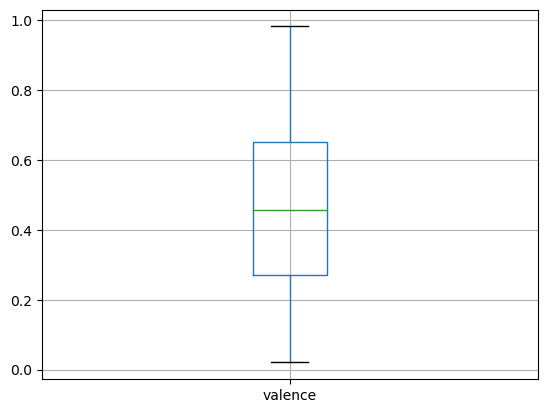

In [20]:
print('Распределение количественных значений в df_test')
for col in num_columns_test:
    num_values_boxplot(df_test)

Распределения количественных данных в тренировочном и тестовом датафреймах схожи. Наблюдаются аномалии: продолжительность -1 и инструментальность 0 - вероятно, это заглушки для отсутствующих значений. Кроме этого, выбросами являются композиции с продолжительностью менее 1316 мс (рекорд Гиннесса - самая короткая музыкальная композиция).

## Обработка и подготовка данных для машинного обучения

Превратим признак названия в количество слов в нём в обоих датафреймах.

In [21]:
words_count_train=[]
for i in df_train['track_name']:
    words_count_train.append(len(re.findall(r'\w+', i)))
df_train['track_name'] = pd.Series(data=words_count_train, index=df_train.index)

In [22]:
words_count_test=[]
for i in df_test['track_name']:
    words_count_test.append(len(re.findall(r'\w+', i)))
df_test['track_name'] = pd.Series(data=words_count_test, index=df_test.index)

Поставим пропуски на нулевых названиях треков, заглушках и выбросах.

In [23]:
df_train['track_name'] = df_train['track_name'].mask(df_train['track_name']==0)
df_train['duration_ms'] = df_train['duration_ms'].mask(df_train['duration_ms']==-1)
df_train['duration_ms'] = df_train['duration_ms'].mask(df_train['duration_ms']<1316)
df_train['instrumentalness'] = df_train['instrumentalness'].mask(df_train['instrumentalness']==0)
df_train.loc[df_train['loudness']>0, ['loudness']] = 0
    

In [24]:
df_test['track_name'] = df_test['track_name'].mask(df_test['track_name']==0)
df_test['duration_ms'] = df_test['duration_ms'].mask(df_test['duration_ms']==-1)
df_test['duration_ms'] = df_test['duration_ms'].mask(df_test['duration_ms']<1316)
df_test['instrumentalness'] = df_test['instrumentalness'].mask(df_test['instrumentalness']==0)
df_test.loc[df_test['loudness']>0, ['loudness']] = 0
    

Разделим обучающие данные на признаки и целевой признак и переопределим количественные и категориальные колонки в них.

In [25]:
X = df_train.drop(labels=['music_genre', 'obtained_date'], axis=1)
y = df_train['music_genre']

In [26]:
cat_columns = ['key', 'mode']
num_columns = ['track_name', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

## Машинное обучение с применением пайплайна

Для предобрабоки данных создаём обрабатывающий дисбалансы пайплайн с детектором выбросов, масштабированием, исключением данных с высокой взаимной корреляцией, заполнением пропусков, созданием синтетических полиномиальных признаков и подбором наилучших параметров через кросс-валидацию.

In [27]:
def outlier_detector_(X, y):
    outlier_index =  IsolationForest(contamination=0.01, random_state=42).fit_predict(X)
    return X[outlier_index == 1], y[outlier_index == 1] 

In [28]:
scaler = RobustScaler()
outlier_detector = FunctionSampler(func=outlier_detector_)
drop_correlation = DropCorrelatedFeatures(threshold=0.9)

In [29]:
num_pipeline = make_imblearn_pipeline(scaler, drop_correlation)
column_transformer = make_column_transformer((OrdinalEncoder(), cat_columns),
                                            (num_pipeline, num_columns))

In [30]:
clf_pipeline =  make_imblearn_pipeline(column_transformer,
                         IterativeImputer(),         
                         FunctionSampler(func=outlier_detector_),
                         PolynomialFeatures(),
                         SelectKBest(score_func=mutual_info_classif),
                         RandomForestClassifier(random_state=42))
clf_pipeline.steps[-1][1].get_params()
clf_pipeline.steps[-1] = ('clf', clf_pipeline.steps[-1][1])

Разделим обучающие данные на тренировочную и валидационную выборки.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

С помощью словаря параметров и рандомизированного поиска с кросс-валидацией перебираем параметры для пайплайна.

In [32]:
params = [{
    'selectkbest__k' : [5, 10, 'all'],
    'columntransformer__pipeline__robustscaler': [None, RobustScaler(), StandardScaler()],
    'columntransformer__pipeline__dropcorrelatedfeatures__threshold': [0.6, 0.7, 0.8, 0.9],
    'iterativeimputer':[SimpleImputer(), IterativeImputer(), KNNImputer()]
}]

In [33]:
grid = RandomizedSearchCV(clf_pipeline,
                          params,
                          cv=3,
                          n_iter=30,
                          verbose=5,
                          random_state=42,
                          scoring='f1_micro',
                          n_jobs=-1)

In [34]:
%%time
grid.fit(X_train, y_train)
grid.predict(X_test)
display(grid.score(X_test, y_test))
display(grid.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


0.46776170630056385

{'selectkbest__k': 'all',
 'iterativeimputer': SimpleImputer(),
 'columntransformer__pipeline__robustscaler': None,
 'columntransformer__pipeline__dropcorrelatedfeatures__threshold': 0.9}

CPU times: user 28.4 s, sys: 1.01 s, total: 29.4 s
Wall time: 6min 35s


In [35]:
num_pipeline = make_imblearn_pipeline(drop_correlation)
column_transformer = make_column_transformer((OrdinalEncoder(), cat_columns),
                                            (num_pipeline, num_columns))

Создаём два пайплайна-эстимейтора с учётом оптимальных настроек на предобработке. В качестве моделей используем классификаторы - наша задача предполагает мультиклассовую классификацию. С учётом размеров исходного датафрейма используем две модели, которые хорошо принимают такие данные - случайный лес и градиентный бустинг с разбитием на корзины. Два эстимейтора мы объединяем через стэкинг с логистической регрессией и проверяем метрику f1 micro на тренировочном датасете.

In [36]:
rf_pipeline =  make_imblearn_pipeline(column_transformer,
                         SimpleImputer(),         
                         FunctionSampler(func=outlier_detector_),
                         PolynomialFeatures(),
                         SelectKBest(k='all'),
                         RandomForestClassifier(class_weight='balanced', warm_start=True, random_state=42))

In [37]:
rf_pipeline.fit(X_train, y_train)
rf_pipeline.predict(X_test)
display(rf_pipeline.score(X_test, y_test))

0.4660455994116205

In [38]:
gbclf_pipeline = make_imblearn_pipeline(column_transformer,
                         SimpleImputer(),         
                         FunctionSampler(func=outlier_detector_),
                         PolynomialFeatures(),
                         SelectKBest(k='all'),
                         HistGradientBoostingClassifier(warm_start=True, random_state=42))

In [39]:
gbclf_pipeline.fit(X_train, y_train)
gbclf_pipeline.predict(X_test)
display(gbclf_pipeline.score(X_test, y_test))

0.47928413826918365

In [42]:
estimators = [
    ('rf', rf_pipeline),
    ('gbclf', gbclf_pipeline)
]
stclf_pipeline = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    n_jobs=-1,
    cv=3
    
)

In [43]:
stclf_pipeline.fit(X_train, y_train)
stclf_pipeline.predict(X_test)
display(stclf_pipeline.score(X_test, y_test))

/Users/nikitagoroshevskiy/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/nikitagoroshevskiy/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nikitagoroshevskiy/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/nikitagoroshevskiy/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nikitagoroshevskiy/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:765: UserWarning: 

0.5094385878891885

[CV 2/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.6, columntransformer__pipeline__robustscaler=None, iterativeimputer=IterativeImputer(), selectkbest__k=10;, score=0.359 total time=  20.8s
[CV 3/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.9, columntransformer__pipeline__robustscaler=None, iterativeimputer=SimpleImputer(), selectkbest__k=all;, score=0.460 total time=  44.7s
[CV 2/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.7, columntransformer__pipeline__robustscaler=None, iterativeimputer=IterativeImputer(), selectkbest__k=5;, score=0.291 total time=  21.2s
[CV 3/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.7, columntransformer__pipeline__robustscaler=StandardScaler(), iterativeimputer=SimpleImputer(), selectkbest__k=5;, score=0.323 total time=  18.7s
[CV 2/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.9, columntransformer__pipeline__robustscaler=None

In [44]:
test_music_genre = stclf_pipeline.predict(df_test)

In [45]:
df_test['music_genre'] = pd.Series(data=test_music_genre, index=df_test.index)

In [46]:
df_test = df_test.reset_index(drop=False)

In [47]:
submit = df_test[['instance_id', 'music_genre']]

In [48]:
submit.to_csv('/Users/nikitagoroshevskiy/Desktop/projects/M1_24DS_plus/music-genre-prediction-m124ds/submit4.csv', index_label=False, index=False)

[CV 1/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.8, columntransformer__pipeline__robustscaler=StandardScaler(), iterativeimputer=IterativeImputer(), selectkbest__k=all;, score=0.439 total time=  37.2s
[CV 3/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.8, columntransformer__pipeline__robustscaler=None, iterativeimputer=KNNImputer(), selectkbest__k=all;, score=0.440 total time=  55.7s
[CV 2/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.6, columntransformer__pipeline__robustscaler=RobustScaler(), iterativeimputer=SimpleImputer(), selectkbest__k=all;, score=0.428 total time=  32.7s
[CV 3/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.8, columntransformer__pipeline__robustscaler=StandardScaler(), iterativeimputer=KNNImputer(), selectkbest__k=10;, score=0.324 total time=  38.4s
[CV 2/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.8, columntransformer__pipeline__

[CV 2/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.8, columntransformer__pipeline__robustscaler=StandardScaler(), iterativeimputer=IterativeImputer(), selectkbest__k=all;, score=0.425 total time=  37.2s
[CV 2/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.8, columntransformer__pipeline__robustscaler=None, iterativeimputer=KNNImputer(), selectkbest__k=all;, score=0.424 total time=  55.6s
[CV 1/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.6, columntransformer__pipeline__robustscaler=RobustScaler(), iterativeimputer=SimpleImputer(), selectkbest__k=all;, score=0.435 total time=  32.6s
[CV 1/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.8, columntransformer__pipeline__robustscaler=StandardScaler(), iterativeimputer=KNNImputer(), selectkbest__k=10;, score=0.315 total time=  38.0s
[CV 3/3] END columntransformer__pipeline__dropcorrelatedfeatures__threshold=0.6, columntransformer__pipeline__

## Краткий итог

По итогам анализа данных установлено наличие пропусков и неявных дубликатов. Вероятно, одни и те же композиции были внесены дважды. При внесении использованы заглушки, качественные категории несбалансированы. Присутствуют недостоверные показатели продолжительности композиций, выгрузка данных могла пройти с ошибками.

С учётом размеров исходного датафрейма используем две модели, которые хорошо принимают такие данные - случайный лес и градиентный бустинг с разбитием на корзины. Два эстимейтора мы объединяем через стэкинг с логистической регрессией и проверяем метрику f1 micro. Метрика составила 0.509.